### Without Pennylane 

In [1]:
from copy import copy, deepcopy
import numpy as np
import scipy as sp
from scipy.optimize import minimize
import pylab
import matplotlib.pyplot as plt
import matplotlib.animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization.bloch import Bloch
from IPython.display import HTML

#### Problem 1
Provide a variational (also called parametric) circuit which is able to generate the most general 1 qubit state. By most general 1 qubit state we mean that there exists a set of the parameters in the circuit such that any point in the Bloch sphere can be reached. Check that the circuit works correctly by showing that by varying randomly the parameters of your circuit you can reproduce correctly the Bloch sphere.

In [2]:
def Rx(theta):
    return np.array([[np.cos(theta/2), -1j * np.sin(theta/2)], [-1j * np.sin(theta/2), np.cos(theta/2)]])

def Rz(phi):
    return np.array([[np.exp(-0.5j * phi), 0], [0, np.exp(0.5j * phi)]])

def circuit_embeding(parameters, initial_state = np.array([1, 0])[:, np.newaxis]): # parameters[0] = theta, parameters[1] = phi
    state = initial_state
    state = np.matmul(Rz(parameters[1]), np.matmul(Rx(parameters[0]), state))
    return state

def qstate_to_bloch_vector(state):
    dm = np.matmul(state, state.conj().T)
    bloch_vector = np.array([2 * dm[0, 1].real, 2 * dm[1, 0].imag, dm[0, 0] - dm[1, 1]]).real
    return bloch_vector

def create_parameter_trajectory(t_list, *args):
    return np.array([f(t_list) for f in args]).T

In [3]:
def sweep_on_bloch_sphere():
    def f_theta(t_list):
        return 2 * np.pi * t_list

    def f_phi(t_list):
        return 20 * np.pi * t_list
    
    def update_bloch_sphere(idx, traj):
        ax.clear()
        plot_bloch_vector(qstate_to_bloch_vector(circuit_embeding(traj[idx])), ax = ax)
        
    traj = create_parameter_trajectory(np.linspace(0, 1, 100), *[f_theta, f_phi])
    fig = plot_bloch_vector(qstate_to_bloch_vector(circuit_embeding(traj[0])))
    ax = fig.gca()
    ani = matplotlib.animation.FuncAnimation(fig, update_bloch_sphere, frames = np.arange(100), interval=30, blit=False, repeat = True, fargs = (traj,))
    HTML(ani.to_html5_video())
    return ani

In [4]:
animation = sweep_on_bloch_sphere()

In [5]:
HTML(animation.to_html5_video())

#### Problem 2
Use the circuit built in step 1) and, using the SWAP test, find the best choice of your parameters to reproduce a randomly generated quantum state made with 1 qubit.

In [83]:
def swap_test(state1, state2):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    I = np.eye(2)
    Z = np.array([[1, 0], [0, -1]])
    CSWAP = np.eye(8)
    CSWAP[5, 5] = 0
    CSWAP[6, 6] = 0
    CSWAP[5, 6] = 1
    CSWAP[6, 5] = 1
    
    state = np.kron(np.kron(zero_state, state1), state2)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    state = np.matmul(CSWAP, state)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    return 1 - np.matmul(np.matmul(state.conj().T, np.kron(np.kron(Z, I), I)), state)[0, 0].real # 0 for same two state and 1 for orthogonal state

In [84]:
def loss_val(parameter, random_state, optimization_traj = []):
    optimization_traj.append(copy(parameter))
    current_state = circuit_embeding(parameter)
    return swap_test(current_state, random_state)

In [97]:
def show_optimization_trajectory_on_bloch_sphere(optimization_traj, figsize = (5, 5), view = (-60, 30)):
    def update(idx, trajectory):
        ax.clear()
        B = Bloch(axes=ax)
        B.add_vectors(trajectory[idx])
        B.add_vectors(qstate_to_bloch_vector(random_state))
        if idx > 10:
            B.add_points(np.array(trajectory[idx - 10:idx]).T)
        elif idx > 0:
            B.add_points(np.array(trajectory[:idx]).T)
        B.render(title=None)
        
    fig = plt.figure(figsize=figsize)
    ax = Axes3D(fig, azim=view[0], elev=view[1])
    ax.set_axis_off()
    ax.set_xlim3d(-0.7, 0.7)
    ax.set_ylim3d(-0.7, 0.7)
    ax.set_zlim3d(-0.7, 0.7)
    
    fig.set_size_inches(figsize[0], figsize[1])
    trajectory_on_Bloch_sphere = np.array([qstate_to_bloch_vector(circuit_embeding(point)) for point in optimization_traj])
    ani = matplotlib.animation.FuncAnimation(fig, 
                                             update, 
                                             frames = np.arange(len(trajectory_on_Bloch_sphere)), 
                                             interval=50, blit=False, repeat = False, 
                                             fargs = (trajectory_on_Bloch_sphere,))
    return ani

True
answer: [0.91682642 0.6696453 ]
optimized solution: [0.91684525 0.66951064]


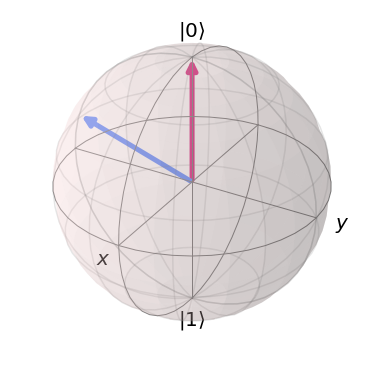

In [98]:
# randomly generated quantum state: random_state
random_parameter = 2 * np.pi * np.random.random(2)
random_state = circuit_embeding(random_parameter)
optimization_traj = []
res = minimize(loss_val, np.array([0, 0]), method='COBYLA', args = (random_state, optimization_traj, ))
print(res.success)
print("answer: " + str(random_parameter))
print("optimized solution: " + str(res.x))
animation = show_optimization_trajectory_on_bloch_sphere(optimization_traj)
HTML(animation.to_html5_video())

#### Problem 3
Suppose you are given with a random state, made by N qubits, for which you only know that it is a product state and each of the qubits are in the state | 0 > or | 1>. By product state we mean that it can be written as the product of single qubit states, without the need to do any summation. 

For example, the state
|a> = |01>
Is a product state, while the state
|b> = |00> + |11>
Is not.

Perform a qubit by qubit SWAP test to reconstruct the state. This part of the problem can be solved via a simple grid search.


In [145]:
def N_qubit_embeding(parameters, initial_states = None): # parameters[:, 0] = theta, parameters[:, 1] = phi
    if not initial_states:
        initial_states = np.array([1, 0])[np.newaxis, :].repeat(len(parameters), axis = 0)
        
    state = np.zeros_like(initial_states, dtype = complex)    
    for i, (initial_state, parameter) in enumerate(zip(initial_states, parameters)):
        state[i] = circuit_embeding(parameter, initial_state)
        
    return state

In [ ]:
def N_qubit_swap_test(state1, state2):
    zero_state = np.array([1, 0])[:, np.newaxis]
    H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
    I = np.eye(len(state1))
    Z = np.array([[1, 0], [0, -1]])
    CSWAP = np.eye(8)
    CSWAP[5, 5] = 0
    CSWAP[6, 6] = 0
    CSWAP[5, 6] = 1
    CSWAP[6, 5] = 1
    
    state = np.kron(np.kron(zero_state, state1), state2)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    state = np.matmul(CSWAP, state)
    state = np.matmul(np.kron(np.kron(H, I), I), state)
    return 1 - np.matmul(np.matmul(state.conj().T, np.kron(np.kron(Z, I), I)), state)[0, 0].real # 0 for same two state and 1 for orthogonal state

In [143]:
N_qubit_embeding(np.random.random((10, 2)))

array([[0.94290271-0.20789244j, 0.05602831-0.25411815j],
       [0.85412142-0.37388562j, 0.14496569-0.33116626j],
       [0.86299557-0.32103716j, 0.13601031-0.36561591j],
       [0.94848407-0.31181263j, 0.01753046-0.05332485j],
       [0.88920198-0.07355095j, 0.0372243 -0.45002717j],
       [0.90911654-0.31454585j, 0.08928695-0.25806173j],
       [0.83415756-0.35959134j, 0.16554404-0.38401874j],
       [0.92859111-0.03555114j, 0.01413205-0.36912729j],
       [0.90721631-0.14655333j, 0.06288241-0.38926405j],
       [0.95824895-0.24786472j, 0.03569905-0.13801309j]])

In [128]:
parameters = np.random.random((10, 2))

In [124]:
initial_states = np.array([1, 0])[np.newaxis, :].repeat(len(parameters), axis = 0)

In [125]:
initial_states

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0]])

In [121]:
len(np.random.random((10, 2)))

10

### With Pennylane 

In [ ]:
import pennylane as qml
from pennylane import numpy as np

In [ ]:
# Initialize single qubit device with the simple pure-state simulator: default.qubit
device = qml.device("default.qubit", wires=1)

In [ ]:
# define variational circuit for embeding with a parameter
@qml.qnode(device)
def circuit_embeding(parameters):
    qml.RX(parameters[0], wires = 0)
    qml.RY(parameters[1], wires = 0)
    return qml.expval(qml.PauliZ(0))

In [ ]:
print(circuit_embeding([0.54, 0.12]))